#### Notebook to exemplify usage of InnvestigateModel

In [1]:
import torch

import torch.nn as nn
import torch.optim as optim


from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from mnist_test import Net, train, test

In [2]:
# Network parameters
class Params(object):
    batch_size = 64
    test_batch_size = 20
    epochs = 5
    lr = 0.01
    momentum = 0.5
    no_cuda = True
    seed = 1
    log_interval = 10
    
    def __init__(self):
        pass

args = Params()
torch.manual_seed(args.seed)
device = torch.device("cpu")
kwargs = {}

###  Load data

In [3]:
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

### Train model

In [23]:
model = Net().to(device)
dropper = nn.Dropout2d()
dropper.train(True)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)
torch.save(model.state_dict(), "./mymodel")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332586
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.323807
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.262323
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.307054
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.248528
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.214086
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.219406
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.205292
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.088662
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.981406
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.929761
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.844703
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.841034
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.777270
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.767565
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.510257
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.443801
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.443562
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.388440
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.218236
Train Epoch: 1 [12800/60000 (

## Innvestigate

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

from innvestigator import InnvestigateModel
from utils import Flatten

In [5]:
model = Net()
model.load_state_dict(torch.load("./mymodel"))
# Convert to innvestigate model
inn_model = InnvestigateModel(model, lrp_exponent=2,
                              method="e-rule",
                              beta=.5)

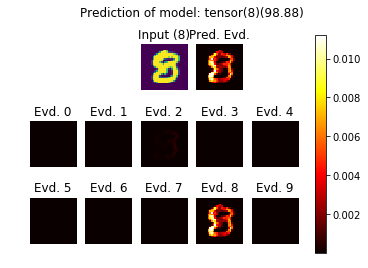

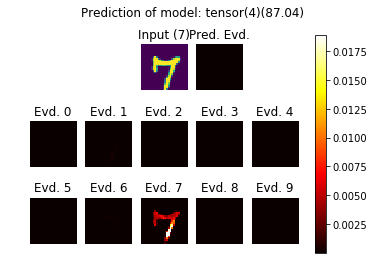

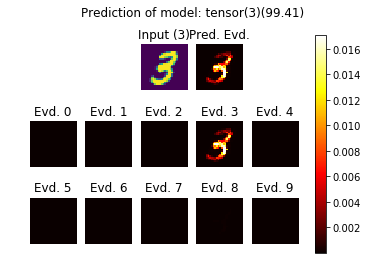

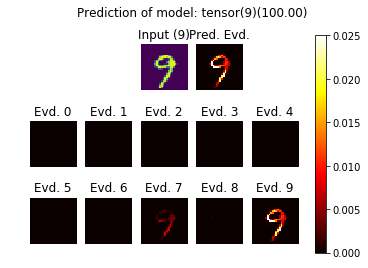

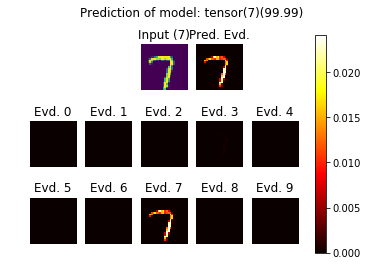

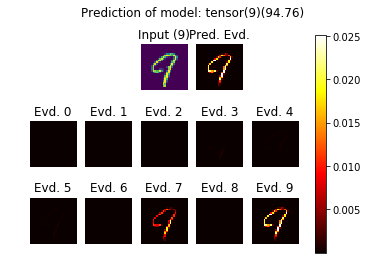

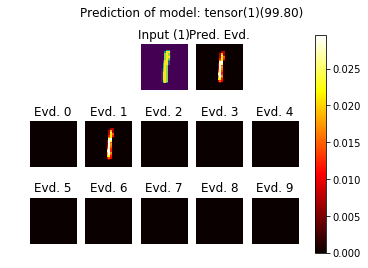

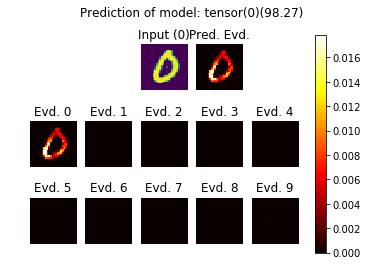

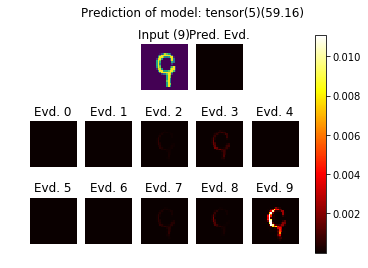

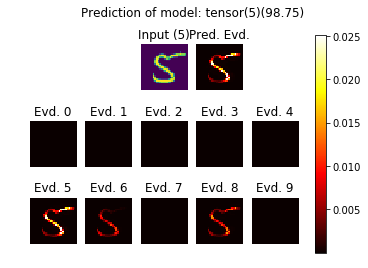

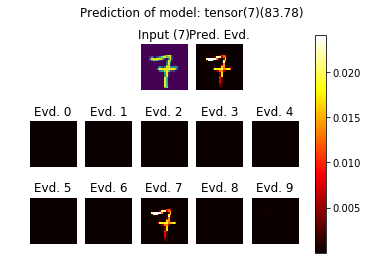

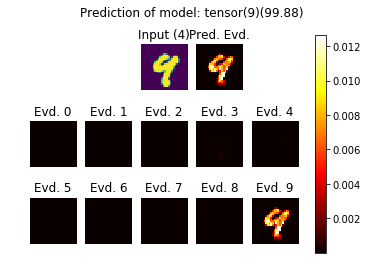

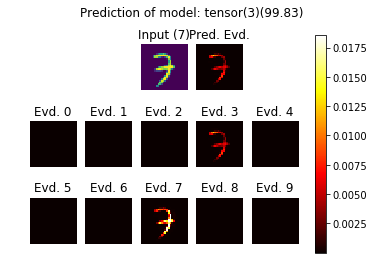

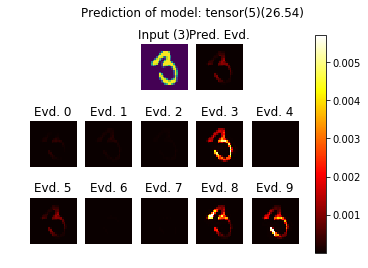

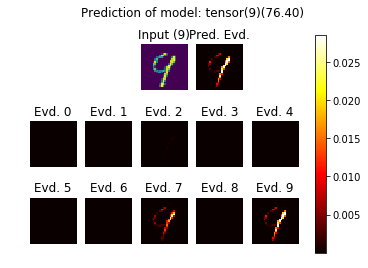

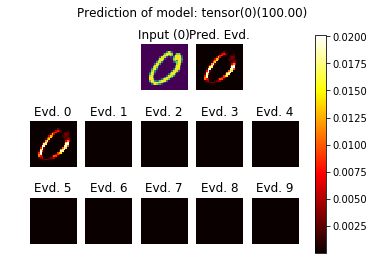

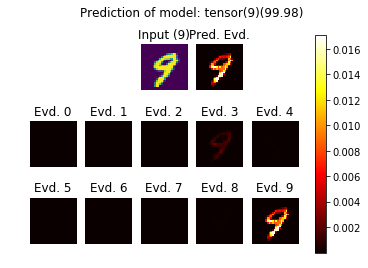

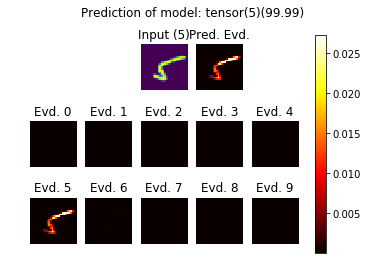

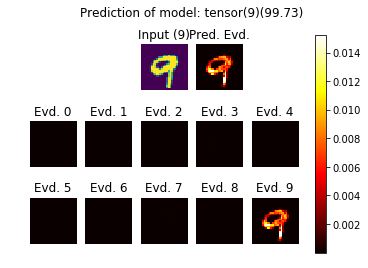

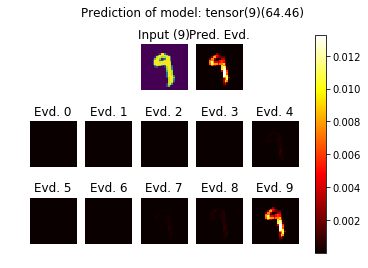

In [6]:
for data, target in test_loader:

    data, target = data.to(device), target.to(device)
    batch_size = int(data.size()[0])

    evidence_for_class = []
    # Overlay with noise 
    # data[0] += 0.25 * data[0].max() * torch.Tensor(np.random.randn(28*28).reshape(1, 28, 28))
    model_prediction, true_relevance = inn_model.innvestigate(in_tensor=data)

    for i in range(10):
        # Unfortunately, we had some issue with freeing pytorch memory, therefore 
        # we need to reevaluate the model separately for every class.
        model_prediction, input_relevance_values = inn_model.innvestigate(in_tensor=data, rel_for_class=i)
        evidence_for_class.append(input_relevance_values)
    
    
    evidence_for_class = np.array([elt.numpy() for elt in evidence_for_class])
    for idx, example in enumerate(data):

        prediction = np.argmax(model_prediction.detach(), axis=1)
        

        fig, axes = plt.subplots(3, 5)
        fig.suptitle("Prediction of model: " + str(prediction[idx]) + "({0:.2f})".format(
            100*float(model_prediction[idx][model_prediction[idx].argmax()].exp()/model_prediction[idx].exp().sum())))
        
        vmin = np.percentile(evidence_for_class[:, idx], 50)
        vmax = np.percentile(evidence_for_class[:, idx], 99.9)
        
        axes[0, 2].imshow(example[0])
        axes[0, 2].set_title("Input (" + str(int(target[idx]))+ ")")
        axes[0, 3].imshow(evidence_for_class[prediction[idx]][idx][0], vmin=vmin,
                          vmax=vmax, cmap="hot")
        axes[0, 3].set_title("Pred. Evd.")
        for ax in axes[0]:
            ax.set_axis_off()
        for j, ax in enumerate(axes[1:].flatten()):
            im = ax.imshow(evidence_for_class[j][idx][0], cmap="hot", vmin=vmin,
                          vmax=vmax)
            ax.set_axis_off()
            ax.set_title("Evd. " + str(j))
        fig.colorbar(im, ax=axes.ravel().tolist())
        plt.show()
    break
        # fig.savefig("./mnist_example{0}.png".format(idx))